In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sc
import itertools
from operator import itemgetter
from matplotlib import pyplot as plt
from add_titleScore import *
import seaborn as sns
sns.set(style="whitegrid")
os.chdir('/Users/Gabi/Documents/projects/opps_model/')
data_path = os.getcwd() + '/data/'
os.chdir('./src/')

cleaned_data = 'exportMatch_03072017.csv' # has created & stages (includes all stages)
stage_data = 'stage_data_03072017.csv' #stagechanges only
avg_dur_data = 'data_for_AVG.csv' # data that follows process & outliers removed in days in stage
newbusfile = 'newbus.csv' #newbusiness only
existbusfile = 'existbus.csv'#existing business only

In [3]:
stages = ['Prospect', 'Qualified', 'Buying Process id.', 'Short List', 'Chosen Vendor', 'Negotiation/Review',
          'PO In Progress', 'Closed Won']
lost = ['Closed Deferred', 'Closed Lost']

impt_stages = list(itertools.combinations(stages[1:], 2))

stage_dict = {'Qualified' : impt_stages[0:6], 'Buying Process id.' : impt_stages[6:11], 'Short List' : impt_stages[11:15],
              'Chosen Vendor' : impt_stages[15:18], 'Negotiation/Review' : impt_stages[18:20],
              'PO In Progress' : impt_stages[-1]}
# stages that follow process
opp_stages = zip(stages[::1], stages[1::1])

forward_stages = list(itertools.combinations(stages[0:], 2))
backward_stages = list(itertools.combinations(stages[-1::-1], 2))

won_stages = list(itertools.product(stages[1:-1],['Closed Won']))

lostdef_stages = list(itertools.product(stages[1:], lost))
lost_stages = [i for i in  lostdef_stages if i[1]=='Closed Lost']
deferred_stages = [i for i in  lostdef_stages if i[1]=='Closed Deferred']

In [4]:
industry_map = {
"Asset Management":"Financial Services",
"Banking":"Financial Services",
"Insurance":"Financial Services",
"Financial Services: Other":"Financial Services",
"Healthcare Payer":"Healthcare",
"Healthcare Provider":"Healthcare",
"Healthcare Payer and Provider":"Healthcare",
"Technology":"Technology",
"Government: Federal":"Federal",
"Government":"Federal",
"Government: State and Local":"Federal",
"Life Sciences":"Life Sciences"}

In [5]:
dat = pd.read_csv(data_path + stage_data, index_col=0)
dat_AVG = pd.read_csv(data_path + avg_dur_data, index_col=0)
newbus = pd.read_csv(data_path + 'newbus.csv')
existbus = pd.read_csv(data_path + 'existbus.csv')

In [6]:
# dat - only includes stage changes
print "all data size", dat.shape
print "size of data used for averages where outliers have been removed" ,dat_AVG.shape
print "# opps for avgs", dat_AVG.OpportunityID.nunique()

all data size (3622, 36)
size of data used for averages where outliers have been removed (857, 36)
# opps for avgs 585


In [7]:
dat.qt = pd.PeriodIndex(dat.qt, freq ='Q-SEP')
dat['OldNewStage'] = zip(dat.OldValue, dat.NewValue) #this comes over as a str instead of tuple

In [8]:
# number of rows in data
dat.shape

(3622, 36)

In [9]:
# 1925 if remove prospect & only stagename
print dat.shape

# 1472 if remove prospect & only stagename - new bus
dat[dat.Type == 'New Business'].shape

(3622, 36)


(3110, 36)

In [10]:
dat = dat[(dat.OldValue != 'Prospecting')]
dat = dat[(dat.OldValue != 'Re-Qualify')]
dat = dat[(dat.NewValue != 'Re-Qualify')]
dat = dat[(dat.NewValue != 'Prospect')]
dat = dat[(dat.OldValue != 'Prospect')]

In [11]:
#total number of opportunities in dataset
print "number of opps in data", dat.OpportunityID.nunique()
print "number of opps in data that follow process", dat[dat.OldNewStage.isin(opp_stages)].OpportunityID.nunique()

number of opps in data 972
number of opps in data that follow process 402


In [12]:
# number of opportunities by Fiscal Quarter
print dat.groupby('qt').OpportunityID.nunique()

qt
2016Q1    182
2016Q2    224
2016Q3    348
2016Q4    329
2017Q1    265
Freq: Q-SEP, Name: OpportunityID, dtype: int64


In [13]:
dat.to_csv(data_path + 'stage_dat_04032017.csv')

## New Business vs. Old Business

* Average Stage duration and sales cyles
* New ARR
* Conversion Rates

In [14]:
newbus = dat[dat.Type =='New Business']
existbus = dat[dat.Type =='Existing Business']
newbus.OldNewStage = zip(newbus.OldValue, newbus.NewValue)
existbus.OldNewStage = zip(existbus.OldValue, existbus.NewValue)

print "new bus opps:", newbus.OpportunityID.nunique()
print "exist bus opps:", existbus.OpportunityID.nunique()

new bus opps: 779
exist bus opps: 193


/Users/Gabi/.virtualenvs/opps_analysis/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/Users/Gabi/.virtualenvs/opps_analysis/lib/python2.7/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


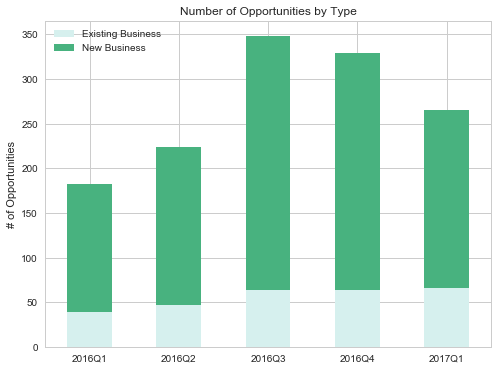

In [15]:
type_qt_grp = dat.groupby(['qt','Type']).OpportunityID.nunique()
# group for count 

# number of closed deferred by qt
type_plt = type_qt_grp.unstack().plot(kind = 'bar',stacked = True, colors =sns.color_palette("BuGn", 4)[0:4:2] ,title = 'Number of Opportunities by Type', figsize=(8,6))
type_plt.set_ylabel('# of Opportunities')
type_plt.set_xlabel('')
xticks = [item.get_text() for item in type_plt.get_xticklabels()]
type_plt.set_xticklabels(labels= xticks, rotation = 0)
type_plt.legend(loc =0)
plt.show()

In [16]:
type_g = dat.groupby('Type')
g_type = dat.groupby(['qt']).OpportunityID.nunique()
res = pd.DataFrame(type_qt_grp.div(g_type, level='qt'))
res.columns = ['percent_type']
res

percent_type
qt     Type                           
2016Q1 Existing Business      0.214286
       New Business           0.785714
2016Q2 Existing Business      0.209821
       New Business           0.790179
2016Q3 Existing Business      0.183908
       New Business           0.816092
2016Q4 Existing Business      0.194529
       New Business           0.805471
2017Q1 Existing Business      0.249057
       New Business           0.750943

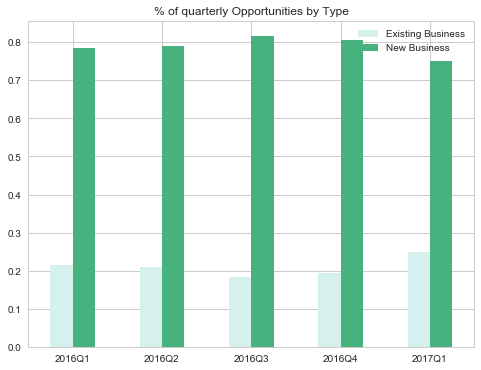

In [17]:
type_plt = type_qt_grp.div(g_type, level='qt').unstack().plot(kind = 'bar',
                                                              colors =sns.color_palette("BuGn", 4)[0:4:2] ,
                                                              title = '% of quarterly Opportunities by Type', figsize=(8,6))
type_plt.set_ylabel('')
type_plt.set_xlabel('')
xticks = [item.get_text() for item in type_plt.get_xticklabels()]
type_plt.set_xticklabels(labels= xticks, rotation = 0)
type_plt.legend(loc ='best')
plt.show()
plt.show()

In [19]:
# how many data points are there?
print "# of New Business Opps: " , newbus.OpportunityID.drop_duplicates().shape[0]
print "# of Existing Business Opps: " , existbus.OpportunityID.drop_duplicates().shape[0]

# of New Business Opps:  779
# of Existing Business Opps:  193


In [20]:
# who won more opps?
print newbus[newbus.OldNewStage.isin(won_stages)].OpportunityID.nunique()
print existbus[existbus.OldNewStage.isin(won_stages)].OpportunityID.nunique()

69
92


In [21]:
# Won & Closed Deferred - New business vs Existing Business
print "New business Won:" , newbus[newbus.OldNewStage.isin(won_stages)].OpportunityID.nunique()
print "New business Closed Deferred:" , newbus[newbus.OldNewStage.isin(deferred_stages)].OpportunityID.nunique()
print 

print "Existing business Won:" , existbus[existbus.OldNewStage.isin(won_stages)].OpportunityID.nunique()
print "Existing business Closed Deferred:" , existbus[existbus.OldNewStage.isin(deferred_stages)].OpportunityID.nunique()


New business Won: 69
New business Closed Deferred: 479

Existing business Won: 92
Existing business Closed Deferred: 66


In [22]:
newbus_avg = dat_AVG[dat_AVG.Type == 'New Business']
exbus_avg = dat_AVG[dat_AVG.Type == 'Existing Business']
newbus_avg['OldNewStage'] = zip(newbus_avg.OldValue, newbus_avg.NewValue) #this comes over as a str instead of tuple
exbus_avg['OldNewStage'] = zip(exbus_avg.OldValue, exbus_avg.NewValue) #this comes over as a str instead of tuple

/Users/Gabi/.virtualenvs/opps_analysis/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Gabi/.virtualenvs/opps_analysis/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
print newbus_avg[newbus_avg.OldNewStage.isin(opp_stages)].groupby('OldNewStage').days_in_stage.mean()
print exbus_avg[exbus_avg.OldNewStage.isin(opp_stages)].groupby('OldNewStage').days_in_stage.mean()

OldNewStage
(Buying Process id., Short List)        33.720930
(Chosen Vendor, Negotiation/Review)     32.717391
(Negotiation/Review, PO In Progress)    40.000000
(PO In Progress, Closed Won)            15.000000
(Prospect, Qualified)                   25.565350
(Qualified, Buying Process id.)         41.375000
(Short List, Chosen Vendor)             41.750000
Name: days_in_stage, dtype: float64
OldNewStage
(Buying Process id., Short List)        37.000000
(Chosen Vendor, Negotiation/Review)     20.133333
(Negotiation/Review, PO In Progress)    28.333333
(PO In Progress, Closed Won)            18.792453
(Prospect, Qualified)                   46.333333
(Qualified, Buying Process id.)         32.500000
(Short List, Chosen Vendor)             35.666667
Name: days_in_stage, dtype: float64


In [25]:
print "New bus avg"
print newbus_avg[newbus_avg.OldNewStage.isin(opp_stages)].groupby(['qt','OldNewStage']).days_in_stage.mean()[0:5]
print "Exist bus avg"
print exbus_avg[exbus_avg.OldNewStage.isin(opp_stages)].groupby(['qt','OldNewStage']).days_in_stage.mean()[0:5]

New bus avg
qt      OldNewStage                         
2016Q1  (Buying Process id., Short List)        26.714286
        (Chosen Vendor, Negotiation/Review)     16.200000
        (Negotiation/Review, PO In Progress)    24.000000
        (PO In Progress, Closed Won)             9.125000
        (Prospect, Qualified)                   12.000000
Name: days_in_stage, dtype: float64
Exist bus avg
qt      OldNewStage                         
2016Q1  (Negotiation/Review, PO In Progress)     6.666667
        (PO In Progress, Closed Won)             6.857143
        (Qualified, Buying Process id.)         23.000000
        (Short List, Chosen Vendor)             23.000000
2016Q2  (Buying Process id., Short List)        24.666667
Name: days_in_stage, dtype: float64


In [26]:
# cleaned up data - follow process + no outliers
dat_AVG.OpportunityID.nunique()

585

In [27]:
# cleaned up data - follow process + no outliers -- quarterly
dat_AVG.groupby('qt').OpportunityID.nunique()

qt
2016Q1     83
2016Q2    214
2016Q3    139
2016Q4    147
2017Q1     95
Name: OpportunityID, dtype: int64

In [28]:
dat_AVG.groupby(['Type','OldNewStage']).days_in_stage.mean()

Type               OldNewStage                             
Existing Business  ('Buying Process id.', 'Short List')        37.000000
                   ('Chosen Vendor', 'Negotiation/Review')     20.133333
                   ('Negotiation/Review', 'PO In Progress')    28.333333
                   ('PO In Progress', 'Closed Won')            18.792453
                   ('Prospect', 'Qualified')                   46.333333
                   ('Qualified', 'Buying Process id.')         32.500000
                   ('Short List', 'Chosen Vendor')             35.666667
New Business       ('Buying Process id.', 'Short List')        33.720930
                   ('Chosen Vendor', 'Negotiation/Review')     32.717391
                   ('Negotiation/Review', 'PO In Progress')    40.000000
                   ('PO In Progress', 'Closed Won')            15.000000
                   ('Prospect', 'Qualified')                   25.565350
                   ('Qualified', 'Buying Process id.')         4

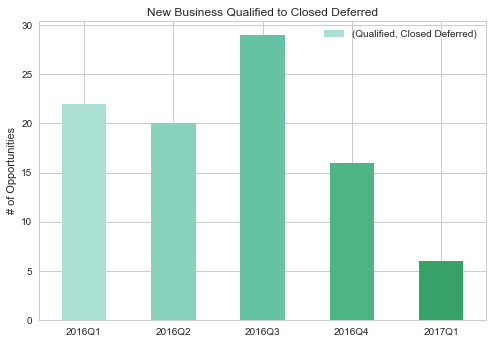

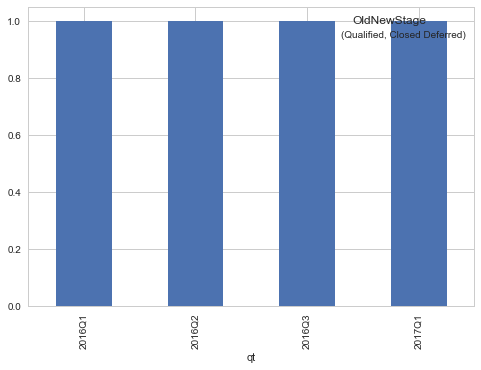

In [29]:
# clean up data w no outliers
nb_q = newbus[(newbus.days_in_stage ==0) & (newbus.OldValue =='Qualified') & (newbus.NewValue =='Closed Deferred')].groupby(['qt','OldNewStage']).OpportunityID.count()
nb_plt = nb_q.unstack().plot(kind = 'bar', stacked = True, colors =sns.color_palette("BuGn", 11)[3::1], title = 'New Business Qualified to Closed Deferred')
nb_plt.set_ylabel('# of Opportunities')
nb_plt.set_xlabel('')
xticks = [item.get_text() for item in nb_plt.get_xticklabels()]
nb_plt.set_xticklabels(labels= xticks, rotation = 0)
nb_plt.legend(loc =0)
plt.show()


eb_q = existbus[(existbus.days_in_stage ==0) & (existbus.OldValue =='Qualified') & (existbus.NewValue =='Closed Deferred')].groupby(['qt','OldNewStage']).OpportunityID.count()
eb_q.unstack().plot(kind = 'bar', stacked = True)
plt.show()


In [31]:
newbus_stage_dur = newbus.groupby('OldNewStage').days_in_stage.mean()
newbus_stage_dur = newbus_stage_dur.where(lambda x: x>0).dropna()
newbus_stage_dur = newbus_stage_dur.reset_index()
newbus_stage_dur.head()

,OldNewStage,days_in_stage
0,"(Buying Process id., Chosen Vendor)",40.950000
1,"(Buying Process id., Closed Deferred)",58.057971
2,"(Buying Process id., Closed Lost)",30.625000
3,"(Buying Process id., Negotiation/Review)",41.333333
4,"(Buying Process id., Qualified)",32.294643


In [32]:
# New Business average stage duration in sales cycle
print "New business Avg stage durations:"
print newbus_stage_dur[newbus_stage_dur.OldNewStage.isin(opp_stages)]

New business Avg stage durations:
                             OldNewStage  days_in_stage
5       (Buying Process id., Short List)      29.828829
9    (Chosen Vendor, Negotiation/Review)      31.767857
26  (Negotiation/Review, PO In Progress)      32.413793
29          (PO In Progress, Closed Won)      13.911765
32       (Qualified, Buying Process id.)      39.389423
39           (Short List, Chosen Vendor)      47.000000


In [33]:
newbus_num_opps = newbus.groupby('OldNewStage').OpportunityID.nunique()
newbus_num_opps = newbus_num_opps.where(lambda x: x>0)
newbus_num_opps = newbus_num_opps.reset_index()
newbus_num_opps.columns = ['OldNewStage','Total_Opps']
# those that dont follow process
newbus_num_opps_2 = newbus_num_opps[~newbus_num_opps.OldNewStage.isin(opp_stages)]
# those that follow process
newbus_num_opps = newbus_num_opps[newbus_num_opps.OldNewStage.isin(opp_stages)]
newbus_num_opps

,OldNewStage,Total_Opps
6,"(Buying Process id., Short List)",105
10,"(Chosen Vendor, Negotiation/Review)",50
31,"(Negotiation/Review, PO In Progress)",28
34,"(PO In Progress, Closed Won)",33
37,"(Qualified, Buying Process id.)",197
45,"(Short List, Chosen Vendor)",64


In [34]:
# Existing Business
existbus_stage_dur = existbus.groupby('OldNewStage').days_in_stage.mean()
existbus_stage_dur= existbus_stage_dur.where(lambda x: x>0).dropna()
existbus_stage_dur = existbus_stage_dur.reset_index()

print "Existing business Avg stage durations:"
print existbus_stage_dur[existbus_stage_dur.OldNewStage.isin(opp_stages)]

Existing business Avg stage durations:
                             OldNewStage  days_in_stage
6       (Buying Process id., Short List)      31.625000
11   (Chosen Vendor, Negotiation/Review)      43.250000
24  (Negotiation/Review, PO In Progress)      17.000000
29          (PO In Progress, Closed Won)      13.847222
31       (Qualified, Buying Process id.)      29.142857
39           (Short List, Chosen Vendor)      30.607143


In [35]:
existbus_num_opps = existbus.groupby('OldNewStage').OpportunityID.nunique()
existbus_num_opps = existbus_num_opps.where(lambda x: x>0)
existbus_num_opps = existbus_num_opps.reset_index()
existbus_num_opps.columns = ['OldNewStage','Total_Opps']

# those that dont follow process
existbus_num_opps_2 = existbus_num_opps[~existbus_num_opps.OldNewStage.isin(opp_stages)]

# those that follow process
existbus_num_opps = existbus_num_opps[existbus_num_opps.OldNewStage.isin(opp_stages)]
existbus_num_opps

,OldNewStage,Total_Opps
7,"(Buying Process id., Short List)",15
12,"(Chosen Vendor, Negotiation/Review)",18
26,"(Negotiation/Review, PO In Progress)",30
31,"(PO In Progress, Closed Won)",70
33,"(Qualified, Buying Process id.)",28
42,"(Short List, Chosen Vendor)",24


In [36]:
print newbus_stage_dur[newbus_stage_dur.OldNewStage.isin(opp_stages[3:-1])]
print
print existbus_stage_dur[existbus_stage_dur.OldNewStage.isin(opp_stages[3:-1])]

                             OldNewStage  days_in_stage
9    (Chosen Vendor, Negotiation/Review)      31.767857
26  (Negotiation/Review, PO In Progress)      32.413793
39           (Short List, Chosen Vendor)      47.000000

                             OldNewStage  days_in_stage
11   (Chosen Vendor, Negotiation/Review)      43.250000
24  (Negotiation/Review, PO In Progress)      17.000000
39           (Short List, Chosen Vendor)      30.607143


In [37]:
# look at lost/deferred by qt
def_dat = dat[dat.OldNewStage.isin(deferred_stages)]
# group for count 
def_grp = dat[dat.OldNewStage.isin(deferred_stages)].groupby(['qt','OldNewStage']).OpportunityID.nunique()
lost_grp = dat[dat.OldNewStage.isin(lost_stages)].groupby(['qt','OldNewStage']).OpportunityID.nunique()
def_grp .head()
# print lost_grp.head()

qt      OldNewStage                          
2016Q1  (Buying Process id., Closed Deferred)    13
        (Chosen Vendor, Closed Deferred)          2
        (Negotiation/Review, Closed Deferred)     2
        (Qualified, Closed Deferred)             25
        (Short List, Closed Deferred)             4
Name: OpportunityID, dtype: int64

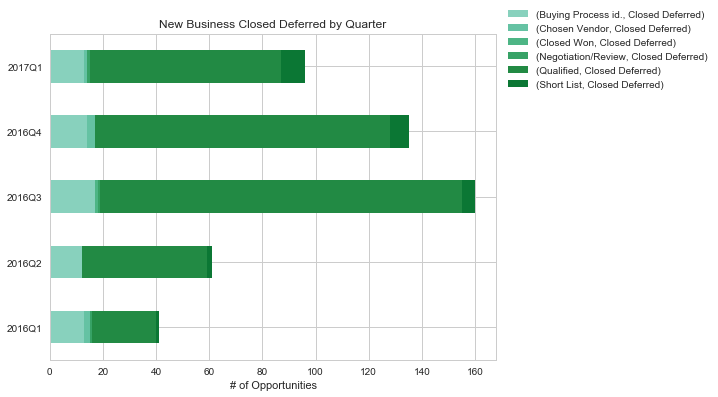

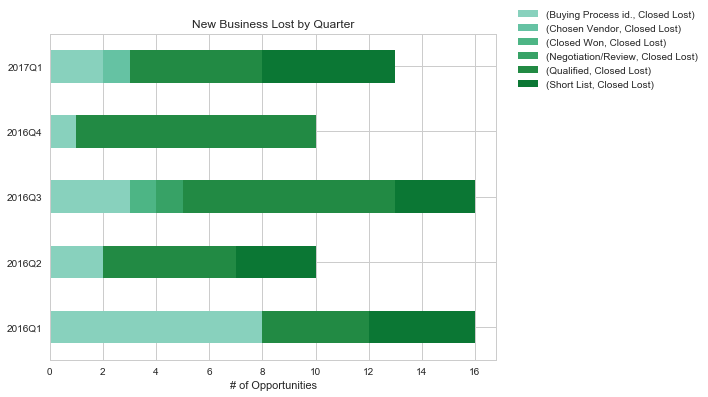

In [38]:
# NEW BUSINESS CLOSED DEFERRED & LOST
newbus_def = dat[(dat.OldNewStage.isin(deferred_stages)) & (dat.Type=='New Business')]
newbus_lost = dat[(dat.OldNewStage.isin(lost_stages)) & (dat.Type=='New Business')]
newbus_def_grp = newbus_def.groupby(['qt','OldNewStage']).OpportunityID.nunique()
newbus_lost_grp = newbus_lost.groupby(['qt','OldNewStage']).OpportunityID.nunique()
# number of closed deferred by qt
nb_def_plt = newbus_def_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'New Business Closed Deferred by Quarter', figsize=(8,6))
nb_def_plt.set_xlabel('# of Opportunities')
nb_def_plt.set_ylabel('')
nb_def_plt.legend(loc =10, bbox_to_anchor=(1.25, .95))
plt.show()

# number of lost by qt
nb_lost_plt = newbus_lost_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'New Business Lost by Quarter', figsize=(8,6))
nb_lost_plt.set_xlabel('# of Opportunities')
nb_lost_plt.set_ylabel('')
nb_lost_plt.legend(loc =10, ncol=1, bbox_to_anchor=(1.25, .95))
plt.show()

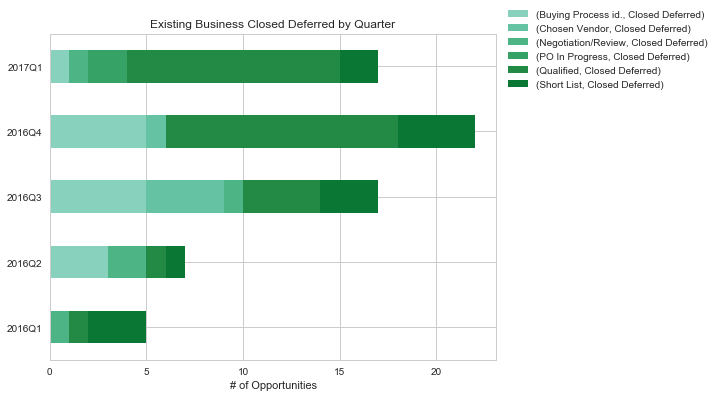

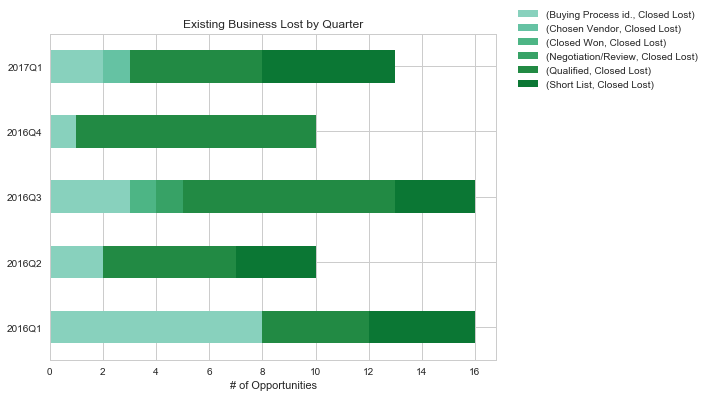

In [39]:
# EXISTING BUSINESS CLOSED DEFERRED & LOST
exbus_def = dat[(dat.OldNewStage.isin(deferred_stages)) & (dat.Type=='Existing Business')]
exbus_lost = dat[(dat.OldNewStage.isin(lost_stages)) & (dat.Type=='Existing Business')]
exbus_def_grp = exbus_def.groupby(['qt','OldNewStage']).OpportunityID.nunique()
exbus_lost_grp = exbus_lost.groupby(['qt','OldNewStage']).OpportunityID.nunique()
# number of closed deferred by qt
eb_def_plt = exbus_def_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'Existing Business Closed Deferred by Quarter', figsize=(8,6))
eb_def_plt.set_xlabel('# of Opportunities')
eb_def_plt.set_ylabel('')
eb_def_plt.legend(loc =10, bbox_to_anchor=(1.25, .95))
plt.show()

# number of lost by qt
eb_lost_plt = newbus_lost_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'Existing Business Lost by Quarter', figsize=(8,6))
eb_lost_plt.set_xlabel('# of Opportunities')
eb_lost_plt.set_ylabel('')
eb_lost_plt.legend(loc =10, ncol=1, bbox_to_anchor=(1.25, .95))
plt.show()

In [40]:
def_opps = dat[dat.OldNewStage.isin(deferred_stages)].OpportunityID.nunique()
print "percent of opps deferred, New Bus", float(newbus_def.OpportunityID.nunique())/def_opps
print "percent of opps deferred, Exist Bus", float(exbus_def.OpportunityID.nunique())/def_opps

percent of opps deferred, New Bus 0.878899082569
percent of opps deferred, Exist Bus 0.121100917431


In [41]:
# percent closed deferred of total each type
print "percent of New Business, opps deferred", float(newbus_def.OpportunityID.nunique())/newbus.OpportunityID.nunique()
print "percent of Existing Business, opps deferred", float(exbus_def.OpportunityID.nunique())/existbus.OpportunityID.nunique()

percent of New Business, opps deferred 0.614890885751
percent of Existing Business, opps deferred 0.341968911917


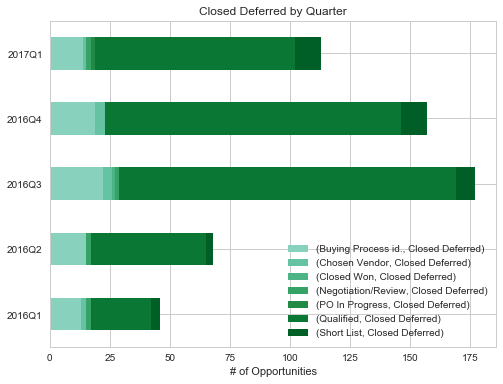

In [42]:
# number of closed deferred by qt
def_plt = def_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'Closed Deferred by Quarter', figsize=(8,6))
def_plt.set_xlabel('# of Opportunities')
def_plt.set_ylabel('')
def_plt.legend( loc =4)
plt.show()

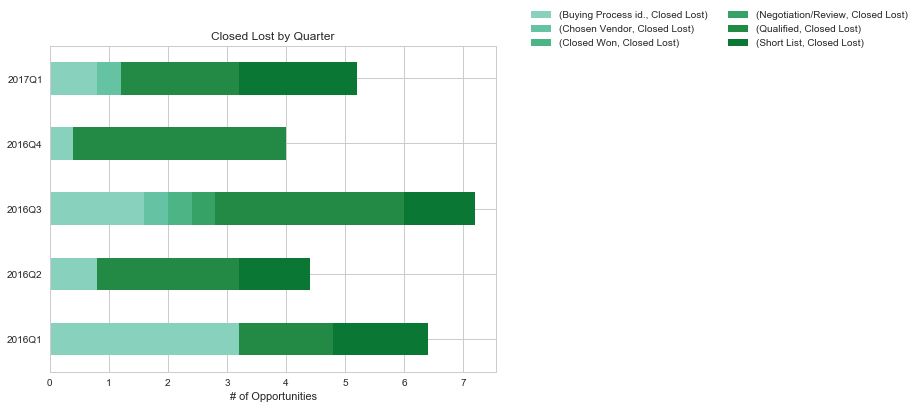

In [43]:
# number of closed lost by qt
lost_plt = lost_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 11)[4:] ,title = 'Closed Lost by Quarter', figsize=(8,6))
lost_plt.set_xlabel('# of Opportunities')
lost_plt.set_ylabel('')
lost_plt.legend(loc =10, ncol=2, bbox_to_anchor=(1.5, 1.05))
xticks = xrange(0, 8)
lost_plt.set_xticklabels(xticks)
plt.show()

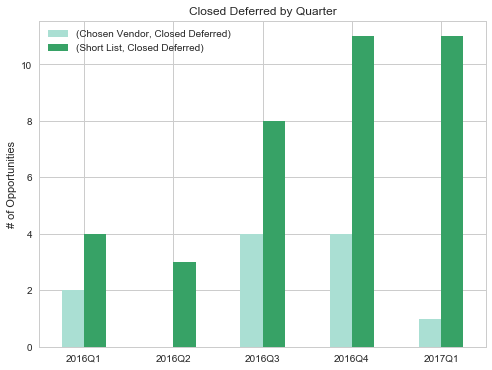

In [44]:
# look at short list and chosen vendor to closed deferred
shortchosen = dat[dat.OldNewStage.isin(deferred_stages[2:4])]
# group for count 
shortchosen_grp = shortchosen.groupby(['qt','OldNewStage']).OpportunityID.nunique()
# number of closed deferred by qt
sc_plt = shortchosen_grp.unstack().plot(kind = 'bar',stacked = False, colors =sns.color_palette("BuGn", 2) ,title = 'Closed Deferred by Quarter', figsize=(8,6))
sc_plt.set_ylabel('# of Opportunities')
sc_plt.set_xlabel('')
xticks = [item.get_text() for item in sc_plt.get_xticklabels()]
sc_plt.set_xticklabels(labels= xticks, rotation = 0)
sc_plt.legend(loc =0)
plt.show()

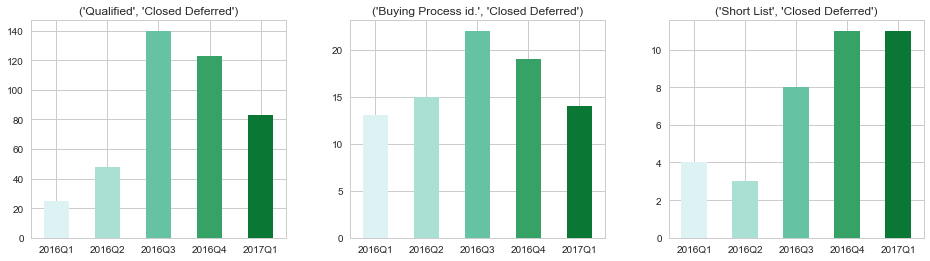

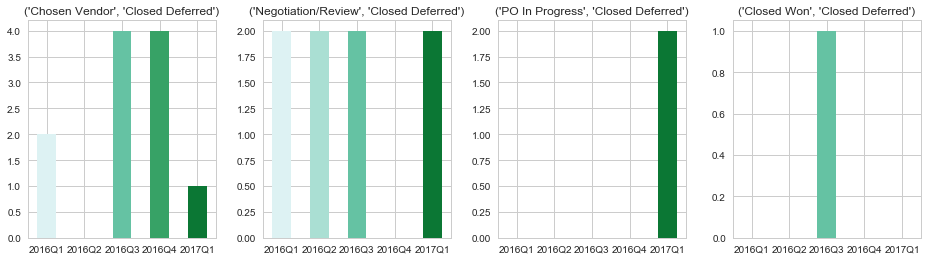

[('Qualified', 'Closed Deferred'),
 ('Buying Process id.', 'Closed Deferred'),
 ('Short List', 'Closed Deferred'),
 ('Chosen Vendor', 'Closed Deferred'),
 ('Negotiation/Review', 'Closed Deferred'),
 ('PO In Progress', 'Closed Deferred'),
 ('Closed Won', 'Closed Deferred')]

In [45]:
import matplotlib.dates as mdates

colors =sns.color_palette("BuGn", 3)
myFmt = mdates.DateFormatter('%Y-%m-%d')

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(deferred_stages[:3]):
    def_plt = def_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in def_plt.get_xticklabels()]
    def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)


fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(deferred_stages[3:]):
    def_plt = def_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in def_plt.get_xticklabels()]
    def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)

deferred_stages

In [46]:
# Lost
lost_grp = dat[dat.OldNewStage.isin(lost_stages)].groupby(['qt','OldNewStage']).OpportunityID.nunique()

In [47]:
lost_grp.reset_index()['OldNewStage'].drop_duplicates().tolist() #lost_stages

[('Buying Process id.', 'Closed Lost'),
 ('Qualified', 'Closed Lost'),
 ('Short List', 'Closed Lost'),
 ('Chosen Vendor', 'Closed Lost'),
 ('Closed Won', 'Closed Lost'),
 ('Negotiation/Review', 'Closed Lost')]

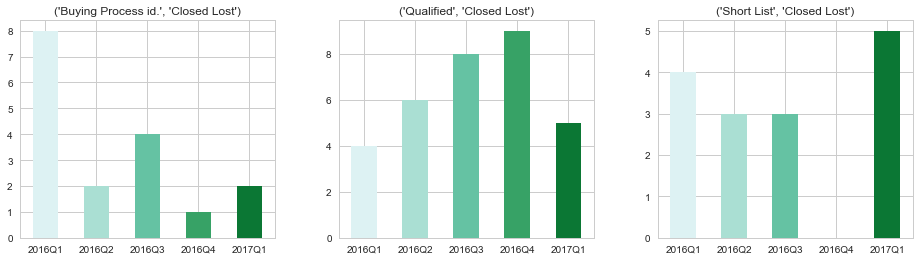

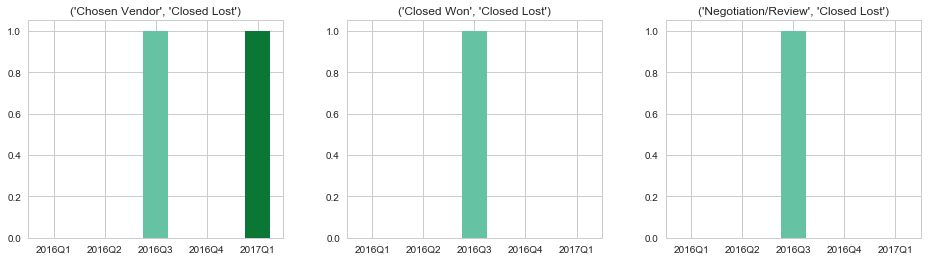

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
lost_s = lost_grp.reset_index()['OldNewStage'].drop_duplicates().tolist()
for idx, s in enumerate(lost_s[:3]):
    lst_plt = lost_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in lst_plt.get_xticklabels()]
    lst_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)


fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(lost_s[3:]):
    lst_plt = lost_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in lst_plt.get_xticklabels()]
    lst_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)

In [49]:
# new business deferred
nb_def_grp = dat[(dat.OldNewStage.isin(deferred_stages)) & (dat.Type == 'New Business')].groupby(['qt','OldNewStage']).OpportunityID.nunique()

In [50]:
nb_lost_grp = dat[(dat.OldNewStage.isin(lost_stages)) & (dat.Type == 'New Business')].groupby(['qt','OldNewStage']).OpportunityID.nunique()

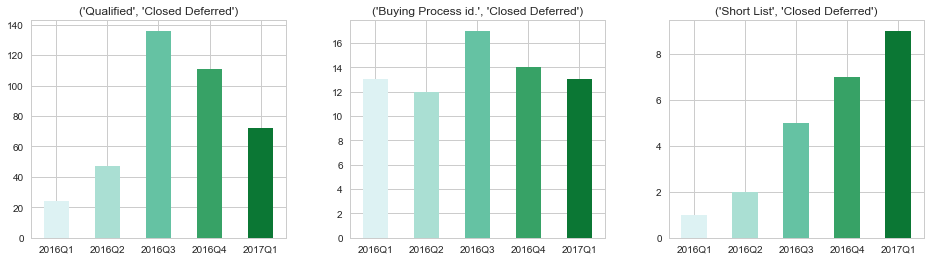

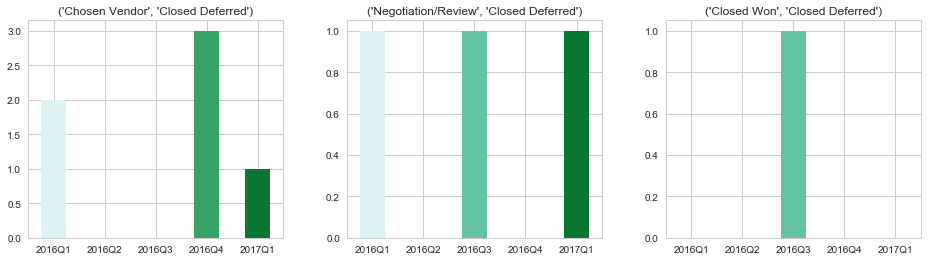

In [53]:
# New Business Closed Deferred
import matplotlib.dates as mdates
colors =sns.color_palette("BuGn", 3)
myFmt = mdates.DateFormatter('%Y-%m-%d')

def_nb_stages = nb_def_grp.reset_index()['OldNewStage'].drop_duplicates().tolist()
l = list(itemgetter(3,0,-2,1,2,-1)(def_nb_stages))

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(l[:3]):
    nb_def_plt = nb_def_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in nb_def_plt.get_xticklabels()]
    nb_def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)


fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(l[3:]):
    nb_def_plt = nb_def_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in nb_def_plt.get_xticklabels()]
    nb_def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)



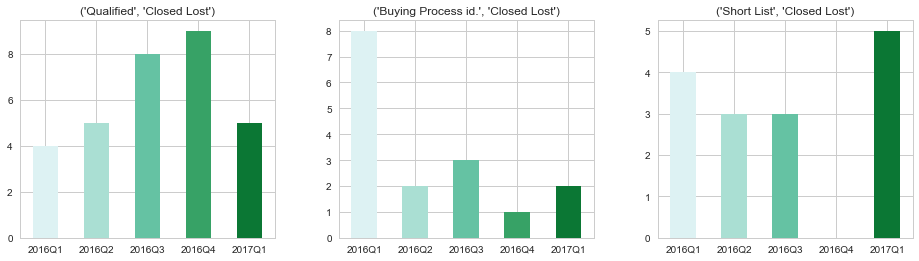

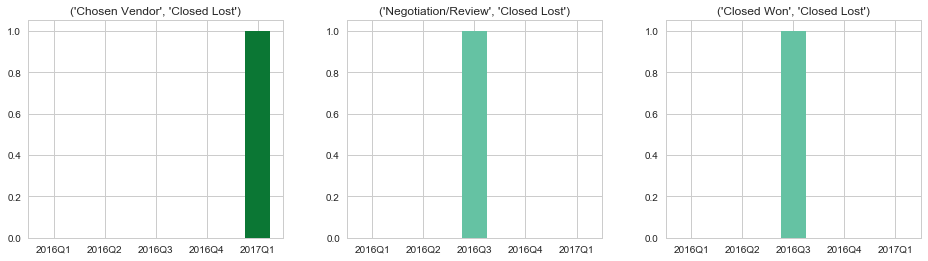

In [54]:
# New Business Closed Lost
import matplotlib.dates as mdates
colors =sns.color_palette("BuGn", 3)
myFmt = mdates.DateFormatter('%Y-%m-%d')

lost_nb_stages = nb_lost_grp.reset_index()['OldNewStage'].drop_duplicates().tolist()
l2 = list(itemgetter(1,0,2,-1,-2,3)(lost_nb_stages))

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(l2[:3]):
    nb_def_plt = nb_lost_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in nb_def_plt.get_xticklabels()]
    nb_def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)


fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (16,4), sharex = True)
fig.subplots_adjust(hspace=.5, wspace=.25)
for idx, s in enumerate(l2[3:]):
    nb_def_plt = nb_lost_grp.unstack()[s].plot(stacked = False, kind = 'bar', ax = axes[idx], colors =sns.color_palette("BuGn", 5))
    axes[idx].set_title(s)
    axes[idx].set_xlabel('')   
    axes[idx].set_ylabel('')
    xticks = [item.get_text() for item in nb_def_plt.get_xticklabels()]
    nb_def_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show(fig)

In [60]:
# number of Qualified to Closed Deferred by time of qt
qual_def = dat[(dat.OldValue =='Qualified') & (dat.OldNewStage.isin(deferred_stages))].groupby(['qt','qt_timing']).OpportunityID.nunique()
qual_def

qt      qt_timing
2016Q1  1            11
        2             6
        3             8
2016Q2  1            11
        2            20
        3            17
2016Q3  1            30
        2            70
        3            40
2016Q4  1            31
        2            36
        3            56
2017Q1  1            21
        2            29
        3            33
Name: OpportunityID, dtype: int64

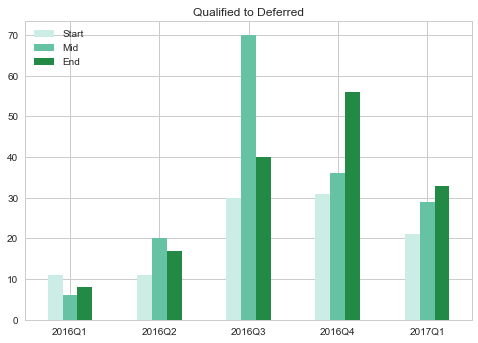

In [59]:
qual_plt = qual_def.unstack().plot(stacked = False, kind = 'bar', colors =sns.color_palette("BuGn", 3), title ='Qualified to Deferred' )
qual_plt.legend(['Start','Mid','End'], loc =2)
qual_plt.set_xlabel('')
xticks = [item.get_text() for item in qual_plt.get_xticklabels()]
qual_plt.set_xticklabels(labels= xticks, rotation = 0)
plt.show()

In [61]:
# closed deferred - New vs Existing
new_def = newbus[newbus.OldNewStage.isin(deferred_stages)]
exist_def = existbus[existbus.OldNewStage.isin(deferred_stages)]

new_def_grp  = new_def.groupby(['qt','OldNewStage']).OpportunityID.nunique()
exist_def_grp = exist_def.groupby(['qt','OldNewStage']).OpportunityID.nunique()

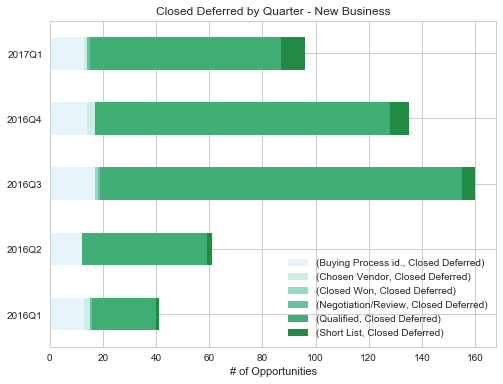

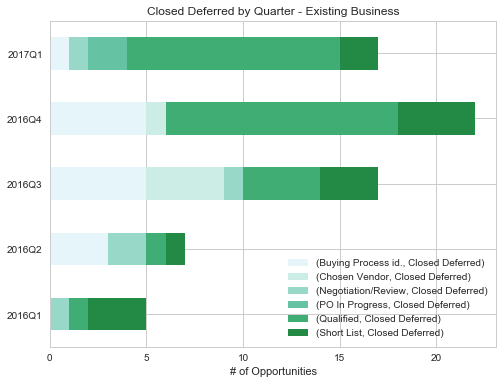

In [62]:
# number of closed deferred by qt - New vs Existing
new_def_plt = new_def_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 7) ,title = 'Closed Deferred by Quarter - New Business', figsize=(8,6))
new_def_plt.set_xlabel('# of Opportunities')
new_def_plt.set_ylabel('')
new_def_plt.legend( loc =4)
plt.show()

exist_def_plt = exist_def_grp.unstack().plot(kind = 'barh',stacked = True, colors =sns.color_palette("BuGn", 7) ,title = 'Closed Deferred by Quarter - Existing Business', figsize=(8,6))
exist_def_plt.set_xlabel('# of Opportunities')
exist_def_plt.set_ylabel('')
exist_def_plt.legend( loc =4)
plt.show()


## Average stage duration for all Opportunities

#### SALES CYCLE STAGE DURATION STATISTICS: MEAN, MEDIAN & STDEV

In [478]:

stage_stats = dat[dat.OldNewStage.isin(opp_stages)].groupby(['OldNewStage']).days_in_stage.agg(['sum','mean','median',sc.std])

In [479]:
stage_stats = stage_stats.join(dat[dat.OldNewStage.isin(opp_stages)].groupby(['OldNewStage']).OpportunityID.nunique())

In [480]:
stage_stats

,sum,mean,median,std,OpportunityID
OldNewStage,,,,,
"(Buying Process id., Short List)",4133,31.075188,20.0,40.958520,126
"(Chosen Vendor, Negotiation/Review)",2698,34.589744,17.5,45.002867,70
"(Negotiation/Review, PO In Progress)",1389,23.150000,10.0,29.990860,59
"(PO In Progress, Closed Won)",1836,16.392857,4.5,32.432149,109
"(Qualified, Buying Process id.)",11150,45.884774,23.0,59.063027,232
"(Short List, Chosen Vendor)",4186,41.860000,23.0,54.410713,92


In [439]:
# AVG STAGE DURATION IN SALES CYCLE
stage_dur = dat.groupby('OldNewStage').days_in_stage.mean()
stage_dur = stage_dur.where(lambda x: x>0).dropna()
stage_dur = stage_dur.reset_index()
stage_dur = stage_dur[stage_dur.OldNewStage.isin(opp_stages)]

In [449]:
# stage duration sum, median and stdev
stage_median = dat.groupby('OldNewStage').days_in_stage.median()
stage_median = stage_median.where(lambda x: x>0).dropna().reset_index()
stage_median = stage_median[stage_median.OldNewStage.isin(opp_stages)]
print "median:\n", stage_median


median:
                             OldNewStage  days_in_stage
5       (Buying Process id., Short List)           20.0
10   (Chosen Vendor, Negotiation/Review)           17.5
28  (Negotiation/Review, PO In Progress)           10.0
33          (PO In Progress, Closed Won)            4.5
36       (Qualified, Buying Process id.)           23.0
43           (Short List, Chosen Vendor)           23.0


In [453]:
stage_stdev = dat.groupby('OldNewStage').days_in_stage.std()
stage_stdev = stage_stdev.where(lambda x: x>0).dropna().reset_index()
stage_stdev = stage_stdev[stage_stdev.OldNewStage.isin(opp_stages)]
print "stdev:\n", stage_stdev

stdev:
                             OldNewStage  days_in_stage
7       (Buying Process id., Short List)      40.958520
12   (Chosen Vendor, Negotiation/Review)      45.002867
28  (Negotiation/Review, PO In Progress)      29.990860
32          (PO In Progress, Closed Won)      32.432149
34       (Qualified, Buying Process id.)      59.063027
42           (Short List, Chosen Vendor)      54.410713


In [422]:
# AVG STAGE DURATION IN SALES CYCLE
stage_dur[stage_dur.OldNewStage.isin(opp_stages)]

,OldNewStage,days_in_stage
7,"(Buying Process id., Short List)",31.075188
12,"(Chosen Vendor, Negotiation/Review)",34.589744
31,"(Negotiation/Review, PO In Progress)",23.150000
36,"(PO In Progress, Closed Won)",16.392857
39,"(Qualified, Buying Process id.)",45.884774
47,"(Short List, Chosen Vendor)",41.860000


In [ ]:
stage_dur[stage_dur.OldNewStage.isin(opp_stages)]

### Industry Section 
* What does the industry distribution look like?
* How many days are spent on average in each stage?
* Distribution of closed deferred by type and industry

In [626]:
# What does the industry distribution look like?
print newbus.groupby('industry').OpportunityID.nunique()
print
print existbus.groupby('industry').OpportunityID.nunique()

industry
Federal                33
Financial Services    287
Healthcare            103
Life Sciences          31
Other                 327
Technology             24
Name: OpportunityID, dtype: int64

industry
Federal                 5
Financial Services    120
Healthcare             11
Life Sciences           6
Other                  42
Technology             13
Name: OpportunityID, dtype: int64


In [643]:
type_res = pd.DataFrame()
type_ind_grp = dat.groupby(['Type','industry']).OpportunityID.nunique()
g_type = dat.groupby(['Type']).OpportunityID.nunique()
res = pd.DataFrame(type_ind_grp.div(g_type, level='Type'))
res.columns = ['percent_type']
res

percent_type
Type              industry                        
Existing Business Federal                 0.025381
                  Financial Services      0.609137
                  Healthcare              0.055838
                  Life Sciences           0.030457
                  Other                   0.213198
                  Technology              0.065990
New Business      Federal                 0.040994
                  Financial Services      0.356522
                  Healthcare              0.127950
                  Life Sciences           0.038509
                  Other                   0.406211
                  Technology              0.029814

In [342]:
ind_labels = res.index.levels[1]

Index([u'Federal', u'Financial Services', u'Healthcare', u'Life Sciences',
       u'Other', u'Technology'],
      dtype='object', name=u'industry')

In [642]:
# avg days in stage by type and industry
# type_ind_avg = pd.DataFrame(dat.groupby(['Type','industry']).days_in_stage.mean())
type_ind_avg = pd.DataFrame(dat.groupby(['Type','industry']).days_in_stage.agg(['mean','median',sc.std]))
type_ind_avg
# number of closed won by type and industry

mean  median         std
Type              industry                                         
Existing Business Federal             59.777778    26.0   86.618095
                  Financial Services  40.085106    15.5   60.886802
                  Healthcare          53.761905    31.0   73.556716
                  Life Sciences       21.428571     6.5   28.316112
                  Other               37.893443    14.0   54.593737
                  Technology          81.562500     7.0  106.468755
New Business      Federal             67.836364    26.0   83.913042
                  Financial Services  53.688226    29.0   67.805117
                  Healthcare          53.473430    27.0   71.049948
                  Life Sciences       71.423077    50.5   66.860506
                  Other               52.664865    23.0   71.233912
                  Technology          36.542373    19.0   49.441474

In [633]:
# Distribution of closed deferred by type and industry

# closed deferred opps grouped by type & industry
ind_def_grp = dat[dat.OldNewStage.isin(deferred_stages)].groupby(['Type','industry'])
ind_def_grp = pd.DataFrame(ind_def_grp.OpportunityID.nunique())
ind_def_grp.columns = ['Closed_Deferred']

ind_def_grp

Closed_Deferred
Type              industry                           
Existing Business Federal                           3
                  Financial Services               37
                  Healthcare                        6
                  Life Sciences                     1
                  Other                            17
                  Technology                        5
New Business      Federal                          25
                  Financial Services              149
                  Healthcare                       65
                  Life Sciences                    20
                  Other                           214
                  Technology                       16

In [634]:
# Distribution of closed won by type and industry

# closed won opps grouped by type & industry
ind_won_grp = dat[dat.OldNewStage.isin(won_stages)].groupby(['Type','industry'])
ind_won_grp = pd.DataFrame(ind_won_grp.OpportunityID.nunique())
ind_won_grp.columns = ['Closed_Won']

ind_won_grp

Closed_Won
Type              industry                      
Existing Business Federal                      2
                  Financial Services          59
                  Healthcare                   5
                  Life Sciences                3
                  Other                       19
                  Technology                   4
New Business      Federal                      2
                  Financial Services          34
                  Healthcare                  15
                  Life Sciences                3
                  Other                       21
                  Technology                   3

In [644]:
# join percenty by type with avg days in stage
res = res.join(type_ind_avg)

In [645]:
# join number of closed deferred
res = res.join(ind_def_grp)

In [646]:
res = res.join(ind_won_grp)
res

percent_type       mean  median  \
Type              industry                                              
Existing Business Federal                 0.025381  59.777778    26.0   
                  Financial Services      0.609137  40.085106    15.5   
                  Healthcare              0.055838  53.761905    31.0   
                  Life Sciences           0.030457  21.428571     6.5   
                  Other                   0.213198  37.893443    14.0   
                  Technology              0.065990  81.562500     7.0   
New Business      Federal                 0.040994  67.836364    26.0   
                  Financial Services      0.356522  53.688226    29.0   
                  Healthcare              0.127950  53.473430    27.0   
                  Life Sciences           0.038509  71.423077    50.5   
                  Other                   0.406211  52.664865    23.0   
                  Technology              0.029814  36.542373    19.0   

                                             std  Closed_Deferred  Closed_Won  
Type              industry                                                     
Existing Business Federal              86.618095                3           2  
                  Financial Services   60.886802               37          59  
                  Healthcare           73.556716                6           5  
                  Life Sciences        28.316112                1           3  
                  Other                54.593737               17          19  
                  Technology          106.468755                5           4  
New Business      Federal              83.913042               25           2  
                  Financial Services   67.805117              149          34  
                  Healthcare           71.049948               65          15  
                  Life Sciences        66.860506               20           3  
                  Other                71.233912              214          21  
                  Technology           49.441474               16           3

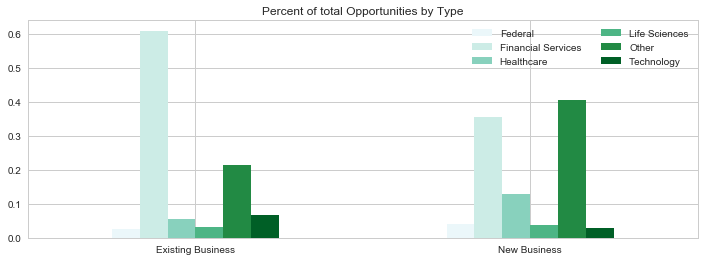

In [421]:
l = ['Existing Business','New Business']
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize= (12,4))
res_pct_plt = res.unstack()['percent_type'].plot(kind='bar', colors = paired_cols, ax = ax)
ax.set_xlabel('')
ax.legend(loc='best', ncol=2, fancybox=True, shadow=True)
plt.title('Percent of total Opportunities by Type')
res_pct_plt.set_xticklabels(labels= l, rotation = 0)
plt.show(fig)

### Add In dept and Sales rep - # opps, stage duration, avg deals

In [706]:
# make sure no nulls
dat.loc[dat.Division.isnull(),'Division'] = 'Admin'

In [707]:
# grouped by division and salesrep
div_res = pd.DataFrame()
div_grp = dat.groupby(['Division','SalesRep']).OpportunityID.nunique()


In [708]:
div_all = dat.groupby(['Division']).OpportunityID.nunique()

In [705]:
dat[dat.Division.isnull()].SalesRep.drop_duplicates()

2851        Tugce Akkalay
3931        Lizbeth Burke
528     Stijn Christiaens
4622         Josh Pollock
Name: SalesRep, dtype: object

In [709]:
pd.DataFrame({'Total': dat.groupby(['Division']).OpportunityID.nunique(),
'Closed_Won':dat[dat.OldNewStage.isin(won_stages)].groupby(['Division']).OpportunityID.nunique(),
'Closed_Lost':dat[dat.OldNewStage.isin(lost_stages)].groupby(['Division']).OpportunityID.nunique(),
'Closed_Deferred':dat[dat.OldNewStage.isin(deferred_stages)].groupby(['Division']).OpportunityID.nunique(),
'Avg_stage_dur': dat.groupby(['Division']).days_in_stage.mean()})

,Avg_stage_dur,Closed_Deferred,Closed_Lost,Closed_Won,Total
Admin,45.008621,50.0,6.0,14.0,76
Inside Sales,48.524950,192.0,18.0,20.0,278
Management,0.000000,2.0,1.0,NaN,3
Partners,35.214286,6.0,NaN,9.0,15
Regional,51.796675,181.0,25.0,54.0,358
SDR,98.000000,NaN,3.0,NaN,6
Sales,19.571429,8.0,NaN,NaN,18
Sales MGR,96.885714,18.0,3.0,2.0,22
Strategic,51.622754,101.0,12.0,71.0,226


In [710]:
print "Closed Deferred by division"
dat[dat.OldNewStage.isin(deferred_stages)].groupby(['Division']).OpportunityID.nunique()

Closed Deferred by division


Division
Admin            50
Inside Sales    192
Management        2
Partners          6
Regional        181
Sales             8
Sales MGR        18
Strategic       101
Name: OpportunityID, dtype: int64

In [711]:
print "Closed Lost by division"
print dat[dat.OldNewStage.isin(lost_stages)].groupby(['Division']).OpportunityID.nunique()
print
print "Closed Won by division"
print dat[dat.OldNewStage.isin(won_stages)].groupby(['Division']).OpportunityID.nunique()



Closed Lost by division
Division
Admin            6
Inside Sales    18
Management       1
Regional        25
SDR              3
Sales MGR        3
Strategic       12
Name: OpportunityID, dtype: int64

Closed Won by division
Division
Admin           14
Inside Sales    20
Partners         9
Regional        54
Sales MGR        2
Strategic       71
Name: OpportunityID, dtype: int64


In [712]:
dat.groupby('Division').SalesRep.unique().to_dict()

{'Admin': array(['Tugce Akkalay', 'Lizbeth Burke', 'Maarten Masschelein',
        'Stijn Christiaens', 'Erin McInerney', 'Josh Pollock'], dtype=object),
 'Inside Sales': array(['Mike Bianchi', 'Akira Lewis', 'Nihal Rao', 'Boris Shvartsman',
        'Sean Arnold'], dtype=object),
 'Management': array(['Benny Verhaeghe'], dtype=object),
 'Partners': array(['Robert Rich'], dtype=object),
 'Regional': array(['Lance Keel', 'Bettina Engelen', 'Mark Favelson', 'Safina Shaheed',
        'Shelemat Daniel', 'Bianca Vloon', 'Greg Ursetta', 'Toby Shean',
        'Trevor Trodd', 'Lauren Raeburn', 'Nanci Uher'], dtype=object),
 'SDR': array(['Tony Fitzgerald'], dtype=object),
 'Sales': array(['Jeffrey Bertrand', 'Catherine Estep'], dtype=object),
 'Sales MGR': array(['Steve Neat', 'Michael Pezza'], dtype=object),
 'Strategic': array(['Greg Smith', 'Michael Amaral', 'Chris Cooper', 'Linda Pollack',
        'Steffan Davies', 'Larry Campobasso', 'Tiffany Hess'], dtype=object)}

In [670]:
# exclude these for now
div_exclude= ['Admin','Management','Partners']
div_grp = dat[~dat.Division.isin(div_exclude)].groupby(['Division','SalesRep']).OpportunityID.nunique()
div_grp
div_totals = dat.groupby(['Division']).OpportunityID.nunique()
div_res = pd.DataFrame({'percent_total':div_grp.div(div_totals, level = 'Division'), 
                        'total_opps': div_grp})
# div_res = pd.DataFrame(div_grp.div(div_totals, level = 'Division'))
# div_res.columns = ['percent_total']
div_res.head()

percent_total  total_opps
Division     SalesRep                                   
Inside Sales Akira Lewis            0.248201          69
             Boris Shvartsman       0.097122          27
             Mike Bianchi           0.294964          82
             Nihal Rao              0.201439          56
             Sean Arnold            0.158273          44

In [671]:
# closed won opps grouped by Division & salesrep
div_won_grp = dat[(dat.OldNewStage.isin(won_stages)) & (~dat.Division.isin(div_exclude))].groupby(['Division','SalesRep'])
div_won_grp = pd.DataFrame(div_won_grp.OpportunityID.nunique())
div_won_grp.columns = ['Closed_Won']

div_won_grp.head()

Closed_Won
Division     SalesRep                    
Inside Sales Akira Lewis                4
             Boris Shvartsman           3
             Mike Bianchi               4
             Sean Arnold                9
Regional     Bettina Engelen            2

In [672]:
# closed deferred opps grouped by Division & salesrep
div_def_grp = dat[(dat.OldNewStage.isin(deferred_stages)) & (~dat.Division.isin(div_exclude))].groupby(['Division','SalesRep'])
div_def_grp = pd.DataFrame(div_def_grp.OpportunityID.nunique())
div_def_grp.columns = ['Closed_Deferred']

div_def_grp.head()

Closed_Deferred
Division     SalesRep                         
Inside Sales Akira Lewis                    47
             Boris Shvartsman               20
             Mike Bianchi                   53
             Nihal Rao                      45
             Sean Arnold                    27

In [673]:
# closed deferred lost grouped by Division & salesrep
div_lost_grp = dat[(dat.OldNewStage.isin(lost_stages)) & (~dat.Division.isin(div_exclude))].groupby(['Division','SalesRep'])
div_lost_grp = pd.DataFrame(div_lost_grp.OpportunityID.nunique())
div_lost_grp.columns = ['Closed_Lost']

div_lost_grp.head()

Closed_Lost
Division     SalesRep                     
Inside Sales Akira Lewis                 4
             Boris Shvartsman            3
             Mike Bianchi                3
             Sean Arnold                 8
Regional     Bettina Engelen             3

In [674]:
# join percenty by type with avg days in stage
div_res = div_res.join(div_won_grp)


In [675]:
div_res.head()

percent_total  total_opps  Closed_Won
Division     SalesRep                                               
Inside Sales Akira Lewis            0.248201          69         4.0
             Boris Shvartsman       0.097122          27         3.0
             Mike Bianchi           0.294964          82         4.0
             Nihal Rao              0.201439          56         NaN
             Sean Arnold            0.158273          44         9.0

In [676]:
div_res = div_res.join(div_lost_grp)
div_res = div_res.join(div_def_grp)
div_res.head()

percent_total  total_opps  Closed_Won  \
Division     SalesRep                                                  
Inside Sales Akira Lewis            0.248201          69         4.0   
             Boris Shvartsman       0.097122          27         3.0   
             Mike Bianchi           0.294964          82         4.0   
             Nihal Rao              0.201439          56         NaN   
             Sean Arnold            0.158273          44         9.0   

                               Closed_Lost  Closed_Deferred  
Division     SalesRep                                        
Inside Sales Akira Lewis               4.0             47.0  
             Boris Shvartsman          3.0             20.0  
             Mike Bianchi              3.0             53.0  
             Nihal Rao                 NaN             45.0  
             Sean Arnold               8.0             27.0

In [678]:
div_res.to_csv(data_path + "division_res.csv")